# Introduction

We explore variational autoencoders.  This lab is adapted from the example in section 8.4 of Chollet, although our implementation is simpler than the one in the book (I think theirs is needlessly complicated in a couple of places).

# Set Runtime Type

Using a GPU runtime is the difference between 30 seconds per epoch and 10 minutes.

# Imports

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Using TensorFlow backend.


# Data

We will explore Variational Autoencoders with the classic MNIST data set.  This is a set of standardized greyscale images of hand written digits from 0 to 9.  Each digit is centered within an image of shape (28, 28, 1).  Here we read in the data, standardize the pixel values to be between 0 and 1, and display the first few observations.  The original purpose of this data set was to classify the digits; we will use it as a way to explore the latent encodings from VAEs.

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

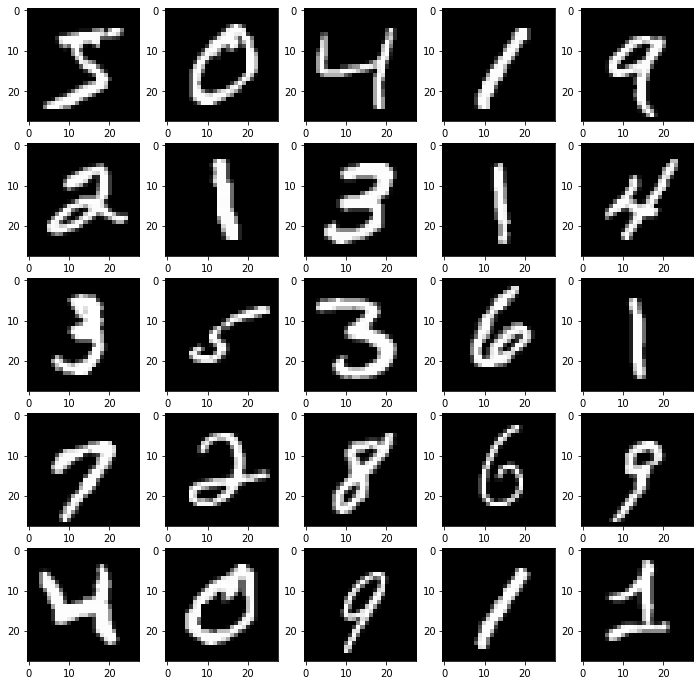

In [3]:
fig,axes = plt.subplots(5, 5, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(x_train[i,:,:,0], cmap='gray')

# Network Specification and Estimation

We will follow the structure given in the book.  We'll split this across six code cells:

1. the encoder network
2. a custom layer that does sampling in the latent encoding space to generate inputs to the decoding network
3. the decoder network
4. define the full VAE model
5. create a custom loss function to use for estimation
6. finally, compile and fit the model

We will want to use the functional API to define this network.  This is necessary because in our formulation the encoding network has two outputs: (a) a vector of means and (b) a vector of log standard deviations for the normal distribution on the encoding in latent space.  Additionally, the decoding network outputs a predicted image.  Generating multiple outputs can be done in the functional API but not in the sequential model API.  Relatedly, the loss function is based on the means and log standard deviations from the encoding network as well as the predicted image from the decoding network; this is a more complicated loss that is not built into Keras, and we will need to be able to refer to all three of those outputs when we write the loss function.

In case you want to refer back to it, our handout about the functional API for Keras is available at http://www.evanlray.com/stat344ne_s2020/resources/keras_functional.pdf.

## 1. Encoder network:

Here's what we'll need for the encoding network:

* **Input layer:**  Our inputs for this example are images of shape (28, 28, 1)
* **Convolutional layers:**
    * 2d convolutional layer with 32 filters, each 3 by 3, with 'same' padding and relu activation
    * 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding, strides=(2,2), and relu activation.  Using the strides will make the output have smaller height and width than the input.
    * 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding, and relu activation.
    * 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding, and relu activation.
* **Flattening and Dense Layer:**
    * Flatten to get a vector suitable for input to a dense layer.  Before flattening, we will record the shape of the output from the last convolutional layer so that later the decoding network can "unflatten" to the appropriate shape.
    * Dense layer with 32 units and relu activation.
* **Outputs from encoding:**
    * means: Dense layer with 2 units representing means for a bivariate normal distribution in a two-dimensional latent encoding space.
    * log(standard deviations): Dense layer with 2 units representing log of standard deviations for a bivariate normal distribution in a two-dimensional latent encoding space.

You will need the following Keras functions (linked to Keras documentation) to specify these layers:

 * [`layers.Input`](https://keras.io/layers/core/#input)
 * [`layers.Conv2D`](https://keras.io/layers/convolutional/#conv2d)
 * [`layers.Flatten`](https://keras.io/layers/core/#flatten)
 * [`layers.Dense`](https://keras.io/layers/core/#dense)




In [0]:
img_shape = (28, 28, 1)

### Encoding Network

## Define input to network using keras.Input().  The input shape is (28, 28, 1).
input_img = layers.Input(shape=img_shape)

## Define convolutional layers.
# 2d convolutional layer with 32 filters, each 3 by 3, with 'same' padding and
# relu activation
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)

# 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding,
# strides=(2,2), and relu activation
x = layers.Conv2D(64, 3, padding='same', activation='relu',
                  strides=(2, 2))(x)

# 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding, and
# relu activation
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

# 2d convolutional layer with 64 filters, each 3 by 3, with 'same' padding, and
# relu activation
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

## Flattening and Dense layer
# save the shape of the representation before flattening it (no need to edit)
shape_before_flattening = K.int_shape(x)

# flatten the convolutional outputs using layers.Flatten
x = layers.Flatten()(x)

# Dense layer with 32 units and relu activation
x = layers.Dense(32, activation='relu')(x)

## define encoding network outputs; we will use a 2 dimensional latent encoding
## space
# mean for the normal distribution
z_mean = layers.Dense(2)(x)

# log standard deviation for the normal distribution
z_log_stddev = layers.Dense(2)(x)

## 2. Custom Layer for Sampling

The outputs of the encoding network are the means and log of the standard deviations for a bivariate normal distribution representing the input's estimated location in the latent embedding space.  The inputs to the decoding network are a single point in the latent embedding space.  To connect these networks, we need a layer that draws a sample from the normal distribution that can then be input to the decoding network.

To do this, the main thing we need to do is write a function that takes a list of tensors as inputs and returns a sampled tensor.  In this case our inputs will be `[z_mean, z_log_stddev]`.  Once we have written that function, we can create a layer based on that function with `layers.Lambda(function)`.

To actually take the sample, the Keras backend function to draw a sample from a Normal(0, 1) distribution is `K.random_normal_variable(shape, mean=0., scale=1.)`.  The automatic differentiation operations in Keras can't trace the derivative through if you just set the mean and scale directly, so we will need to do the following steps:

 * Sample epsilon of shape `(batch size, 2)`, where 2 is the dimension of our latent embedding space.  We can extract the number of observations in the batch as the first entry in the shape of `z_mean`.
 * Calculate the standard deviation by calling `K.exp` on `z_log_stddev`.  Recall that we are doing this transformation to ensure that the standard deviation is positive.
 * return the mean plus the elementwise product of the standard deviation and epsilon.

In [0]:
def sampling(args):
    '''
    generate a sample for input to the decoder network

    Arugments:
     - args: a list of [z_mean, z_log_stddev].  Each has shape (batch size, 2).
    
    Returns:
     - tensor of shape (batch size, 2) sampled from a normal distribution with
       mean z_mean and standard deviation exp(z_log_stddev)
    '''
    # extract z_mean and z_log_stddev from args for easier use (no edits needed)
    z_mean, z_log_stddev = args

    # get batch size as the first dimension of z_mean (or z_log_stddev)
    batch_size = K.shape(z_mean)[0]

    # sample epsilon
    epsilon = K.random_normal(shape=(batch_size, 2), mean=0., stddev=1.)

    # find standard deviation
    z_stddev = K.exp(z_log_stddev)

    # calculate result
    result = z_mean + z_stddev * epsilon

    # return
    return result

# calculate output from sampling.
# no need to modify this code, but check that how it works makes sense to you!
# we create a layer to do sampling with layers.Lambda(sampling) (analogous to
# calling layers.Dense()), and then call that layer with the input list
# [z_mean, z_log_stddev]
z = layers.Lambda(sampling)([z_mean, z_log_stddev])

## 3. Decoder Network

For the decoder network, we basically need to undo all the steps that were done in the encoder network.  One trick is that later, we'd like to be able to use the decoder network as a separate unit, to generate new images by decoding points in the latent space.  Therefore, rather than continuing directly from z, we will specify this as a new network starting with an `Input` layer.  Then we will call this model on the sampled z we set up above.

Use the following structure:
 * **Input layer:** Our inputs for this example have shape (2,) since our latent space has 2 dimensions.
 * **Dense Layer:**
    * The number of units in the dense layer should be the product of the number of units in the `shape_before_flattening` vector giving the length, width, and number of channels in the output from the last convolutional layer:

In [6]:
print("full shape before flattening including batch size = " + str(shape_before_flattening))
print("height, width, and channels before flattening = " + str(shape_before_flattening[1:]))

full shape before flattening including batch size = (None, 14, 14, 64)
height, width, and channels before flattening = (14, 14, 64)


 * **Reshape and convolutional layers:**
    * Reshape the vector output of the dense layer into the shape of the last layer before flattening in the encoder network.
    * Transposed convolutional layer with 64 filters, filter size 3, padding = 'same', and relu activation.  This is the ''opposite'' of the fourth (last) convolutional layer in the encoder network.
    * Transposed convolutional layer with 64 filters, filter size 3, padding = 'same', and relu activation.  This is the ''opposite'' of the third convolutional layer in the encoder network.
    * Transposed convolutional layer with 32 filters, filter size 3, padding = 'same', strides=(2, 2), and relu activation.  This is the ''opposite'' of the second convolutional layer in the encoder network.
    * Convolutional layer with 1 filter, filter size 3, padding = 'same', and sigmoid activation.  This is the ''opposite'' of the first convolutional layer in the encoder network.

Once all those layers are created, you can create the actual decoder model which has the decoder input as input and the output of the last convolutional layer as output.

Finally, you can then create a connection between the encoder rand decoder networks by calling the decoder model with input being the sampled value of z created at the end of step 2 above.

#### Reflection Question 1: Explain in a sentence or two why the last layer in the decoder network has 1 filter and a sigmoid activation.

The output of this filter should be a reconstruction of the original input image, which had shape (28, 28, 1), a gray scale image with one channel.  The pixel values have been scaled to be between 0 and 1, so we need to 

In [0]:
### Input
decoder_input = layers.Input((2,))

### Dense
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

### Reshape and Transposed Convolutional Layers
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(64, 3,
                           padding='same',
                           activation='relu')(x)
x = layers.Conv2DTranspose(64, 3,
                           padding='same',
                           activation='relu')(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# Create decoder model with the Model() function. After this line, you can call
# the model on an input with decoder(input)
decoder = Model(decoder_input, x)

# Call decoder model with z as input
x_tilde = decoder(z)

Here's a summary of your decoder model:

In [8]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289 

## 4. Define VAE Model

We now have all the ingredients required to specify the full vae model, which takes the `input_img` as input and creates `x_tilde` as output.

In [9]:
vae = Model(input_img, x_tilde)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

## 5. Loss

The VAE loss function is not built into Keras, so we will have to create it ourselves.  To perform estimation based on this loss function, we need to write a function to calculate the loss.  Keras requires that the arguments to this function be observed response and the predicted response, and that the function returns the loss separately for each observation in the batch.  Since our observed "response" for the VAE is the original input `x` and the prediction is `x_tilde`, everything needed to calculate the decoder loss will be an argument to the function.  Our function will not receive the outputs from the encoder network as arguments, but that's OK: they are global variables, so they are still accessible within the function.

In the notes, I described the VAE loss function for observation $i$ as:

 * $J^{(i)}(b, w) = J^{(i), Decoder}(b, w) + J^{(i), Encoder}(b, w)$
 * $J^{(i), Decoder}(b, w) = \frac{1}{n_h n_w n_c} \sum_{i = 1}^{n_h} \sum_{j = 1}^{n_w} \sum_{c = 1}^{n_c} (x^{(i)}_{i,j,c} - \tilde{x}^{(i)}_{i,j,c})^2$
 * $J^{(i), Encoder}(b, w) = \frac{1}{2} \sum_{d=1}^D \left[ (\mu_d^{(i)})^2 + (\sigma_d^{(i)})^2 - \log\{ (\sigma_d^{(i)})^2 \} - 1  \right]$

We can see that the decoder loss for each observation is the mean squared error across the last three dimensions of the predictions array, which has shape (observation, height, width, channels).  In our example we have used an encoding dimension of $D=2$, so for the encoder loss we can calculate the term inside the square brackets separately for each observation and embedding dimension using elementwise operations and then take the mean across axis 1 since the mean and log standard deviation arrays have shape (batch_size, 2).

One more detail is that as always, when combining loss functions we can give them different weights.  In the context of a Bayesian analysis, this is equivalent to setting the strength of the prior (if you're not familiar with Bayesian analysis, don't worry about this).  Here we will assign a weight of 1000 to the decoder loss and 1 to the encoder loss.




In [0]:
# Define the VAE loss.
def vae_loss(x, x_tilde):
    '''
    Define the VAE loss function

    Arguments:
     - x: array of shape (batch_size, 28, 28, 1) with observed images
     - x_tilde: array of shape (batch_size, 28, 28, 1) with reconstructed images
    
    Returns:
     - array of shape (batch_size,) with loss per observation
    '''
    decoder_weight=1000.
    encoder_weight=1.

    # calculate decoder loss as mean squared error.
    # to do this, you will want to find the elementwise squared difference
    # between x and x_tilde, and then take the mean with axis = (1,2,3)
    # Use the functions K.square and K.mean
    decoder_loss = K.mean(K.square(x - x_tilde), axis = (1,2,3))

    # calculate encoder loss based on the formula above.  You will need to use
    # K.exp to find the standard deviation based on z_log_stddev.  You will also
    # need to use the functions K.square and K.mean; for K.mean, use axis=1.
    encoder_loss = K.mean(K.square(z_mean) + K.exp(2.*z_log_stddev) - 2.*z_log_stddev - 1, axis=1)

    # calculate combined loss as weighted combination of encoder loss and
    # decoder loss
    combined_loss = decoder_weight*decoder_loss + encoder_weight*encoder_loss

    # return
    return combined_loss

## 6. Compile and fit the model

Compile the model specifying `loss=vae_loss` and using `optimizer='adam'`.

Then fit the model.  Note that `x_train` will be used for both the inputs and the outputs!

In [11]:
vae.compile(loss=vae_loss, optimizer='adam')
vae.fit(x_train, x_train, batch_size=16, verbose=1, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 36s 601us/step - loss: 54.4494
Epoch 2/10
60000/60000 [==============================] - 35s 590us/step - loss: 47.8886
Epoch 3/10
60000/60000 [==============================] - 34s 573us/step - loss: 46.7835
Epoch 4/10
60000/60000 [==============================] - 35s 584us/step - loss: 46.2371
Epoch 5/10
60000/60000 [==============================] - 34s 572us/step - loss: 45.8738
Epoch 6/10
60000/60000 [==============================] - 35s 589us/step - loss: 45.5277
Epoch 7/10
60000/60000 [==============================] - 34s 570us/step - loss: 45.2617
Epoch 8/10
60000/60000 [==============================] - 35s 588us/step - loss: 45.0792
Epoch 9/10
60000/60000 [==============================] - 35s 577us/step - loss: 44.8483
Epoch 10/10
60000/60000 [==============================] - 35s 589us/step - loss: 44.6917


# Visualize the Results

We will create two plots to help us understand the model.  The first shows the encodings of the first 1000 training set observations in the latent space.  This is the output of the encoder model.  The second shows the decoded images corrresponding to a grid of points in the embedding space.  This is the output of the decoder model.

## 1. Visualizing Encoder Output

We will plot just the first 1000 training set observations (the full data set has 60000 observations).  

In [12]:
x_train_1000 = x_train[range(1000), ...]
y_train_1000 = y_train[range(1000), ...]

y_train_1000

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
       9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
       9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
       3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5,
       2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6,
       3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
       9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9,
       6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8,

Recall that the encoder model outputs the mean and variance of a normal disribution in the latent space for each image.  To visualize that distribution, it is enough to display just the mean of that distribution.  To obtain these means, we will need to create a new `Model` that takes `input_img` as input and outputs `z_mean`.

In [0]:
# Create encoder model with the Model() function. After this line, you can call
# the model on an input with encoder(input)
encoder_mean = Model(input_img, z_mean)

To visualize the encoder outputs, we will create a scatter plot with a point for each of the first 1000 training set observations, colored by the response label y for that image.  Note that these responses were not used in training the model!  If the encoder places different images for the same digit near each other in the latent space, it has identified that structure based only on the image data!  This is amazing.

One way to create this scatter plot is as follows:
 * for each `digit` from 0 to 9:
    1. create a boolean vector that is `True` in indices `i` where `y_train_1000[i] == digit` and `False` for all other indices.
    2. create a subset of `x_train_1000` that contains only those observations for which `y_train_1000` is equal to the given digit.  Note that you can use a boolean vector when indexing a numpy array to do this.
    3. find the mean encoding for each image in the subset you created in step 2.  You can call the `encoder_mean.predict(inputs_array)` function to do this, specifying the inputs as appropriate.  The result of this will be an array with shape (number of images, 2) with the mean vector for each image.
    4. add a layer to the scatter plot using `plt.scatter(...)`.  Include `label=digit` to color the point according to the digit.
 * Call `plt.legend()` to add a legend.

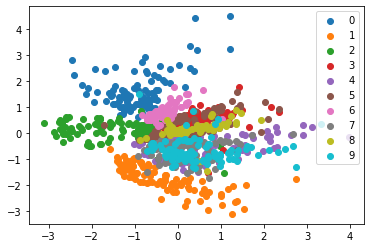

In [14]:
for digit in range(10):
  digit_indicator = (y_train_1000 == digit)
  x_train_subset = x_train_1000[digit_indicator, :]
  z_train_subset = encoder_mean.predict(x_train_subset)

  plt.scatter(z_train_subset[:, 0], z_train_subset[:, 1], label = digit)

plt.legend()

## 2. Visualizing Decoder Output

Here we will create a grid of points in the latent space to feed into the decoder network, and display the resulting generated images.  I'll give you the code for this.  The following code sets up a grid of points and shows them in the latent space.  Note that there are more points near the origin since the VAE places a higher density of encoded points near the origin (this is the effect of the shrinkage term for $\mu$ in the encoder loss function).

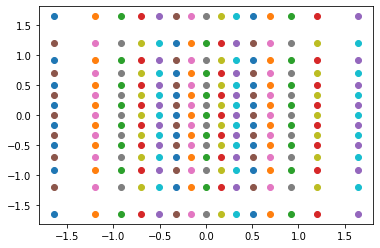

In [15]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for yi in grid_x:
  for xi in grid_y:
    plt.scatter(xi, yi)

Now we iterate through these grid points.  For each point, we feed it into the decoder network and plot it in the corresponding location.  You should see that spatially adjacent images are generally either the same digit, or two different digits with similar structure, such as a 3 and an 8.  (Every time you run this you will get a different result depending on random initialization of the estimation process.)

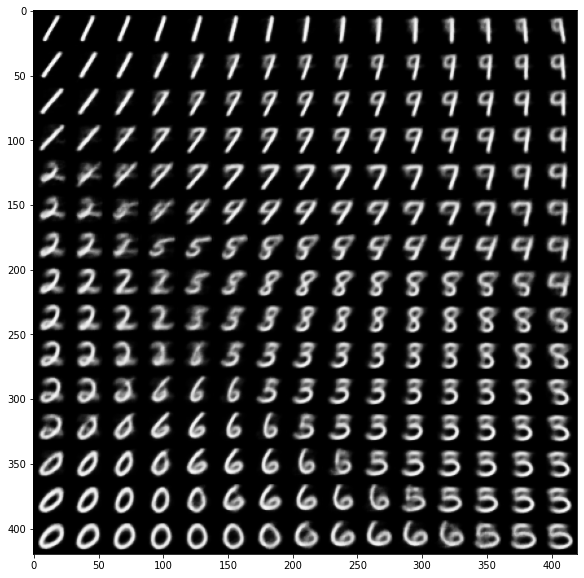

In [16]:
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample, batch_size=16)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
      j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# More Exploration (Optional)

This is completely optional.  One applicaton of VAEs is to human faces.  I was originally going to have you look at that in this lab too, but now it's bed time, so I'm not going to add it here.  However, if you're interested you could scan through this repo that does this; this was set up for part of a workshop that ran at Harvard last year: https://github.com/Harvard-IACS/2019-computefest/tree/master/Wednesday/auto_encoder  Note that they start with the same example we did before moving on to faces.  The MNIST example is a classic example and was featured in the first paper on VAEs.

It would likely take a little work to get the faces example set up to actually run, but you could do it.  You could also just scan through the VAE_solutions.ipynb notebook to see what they did with it.